## i) Import modules/libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install rioxarray --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 32.9 MB/s eta 0:00:00


In [6]:
import os                                 # a module for interacting with the operating system
import sys
import glob                               # used to retrieve files/pathnames matching a specified pattern
import re                                 # re sub() module can be used to replace substring
import rioxarray as rio
import pandas as pd                       # to store and manipulate tabular data in rows of observations and columns of variables
import numpy as np                        # stands for 'Numerical Python, is a python library used for scientific computing with arrays
import calendar
import datetime
from matplotlib import pyplot as plt      # is a plotting library used for 2D graphics in python
from osgeo import gdal

## * Import raster (WaPOR) data

In [24]:
dir_proj = os.path.split(os.getcwd())[0]
dir_data = "/content/drive/MyDrive/Python_mooc/Data"
input_folderAETI = os.path.join(dir_proj, dir_data, "L3-AETI-D")
input_fhsAETI = glob.glob(os.path.join(input_folderAETI, '*.tif'))

input_folderNPP = os.path.join(dir_proj, dir_data, "L3-NPP-D")
input_fhsNPP = glob.glob(os.path.join(input_folderNPP, '*.tif'))

In [25]:
output_folderAETI = "/content/drive/MyDrive/Python_mooc/Data/AETI_season"
output_folderNPP = "/content/drive/MyDrive/Python_mooc/Data/NPP_season"

if not os.path.exists(output_folderAETI):
    os.makedirs(output_folderAETI)
output_folderAETI

if not os.path.exists(output_folderNPP):
    os.makedirs(output_folderNPP)
output_folderNPP

'/content/drive/MyDrive/Python_mooc/Data/NPP_season'

In [34]:
season_periods = {
    'season1': {'SOS': '2020-10-01', 'EOS': '2021-04-30'},
    'season2': {'SOS': '2021-10-01', 'EOS': '2022-04-30'},
    'season3': {'SOS': '2022-10-01', 'EOS': '2023-04-30'}
}

### the function that add one type rasters between two dates

In [27]:
# summation of raster between two dates
def SumSeason(input_fhs, sowing_date, harvesting_date):

    # add rasters that falls within sowing and harvesting date
    Sums = 0
    for i, in_fh in enumerate(input_fhs):
        # open raster file and get start and end date from attributes
        ds = rio.open_rasterio(in_fh)
        ds = ds.where(ds!=ds.attrs['_FillValue'])
        if i == 0:
          attrs = ds.attrs
        raster_startdate = datetime.datetime.strptime(ds.attrs['start_date'], '%Y-%m-%d' ).date()
        raster_enddate   = datetime.datetime.strptime(ds.attrs['end_date'], '%Y-%m-%d' ).date()

        # accumulate full or part of the decadal value
        if (raster_startdate >= sowing_date) & (raster_enddate <= harvesting_date):
            Sum = ds
            Sums += Sum
#             print ("1",in_fh)

        elif (raster_startdate <sowing_date)&(raster_enddate >sowing_date)&(raster_enddate <harvesting_date):
            Sum = ds
            Sum = Sum*((raster_enddate-sowing_date)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("2",in_fh)

        elif (raster_startdate >sowing_date)&(raster_startdate <harvesting_date)&(raster_enddate >harvesting_date):
            Sum = ds
            Sum = Sum*((harvesting_date- raster_startdate)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("3",in_fh)

        elif (sowing_date>=raster_startdate)&(harvesting_date<=raster_enddate):
            Sum = ds
            Sum = Sum*((harvesting_date- sowing_date)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("4",in_fh)
    attrs.update({'start_date':datetime.datetime.strftime(SOS, '%Y-%m-%d'),
              'end_date': datetime.datetime.strftime(EOS, '%Y-%m-%d'),
              'units' : 'mm/season'})
    del attrs['number_of_days']
    del attrs['temporal_resolution']
    del attrs['units_conversion_factor']

    Sums.attrs  = attrs
    return Sums

## ii) Calculate seasonal evapotranspiration and interception

the mean & SD for  2020-10-01/2021-04-30 = 612.7 & 165.4


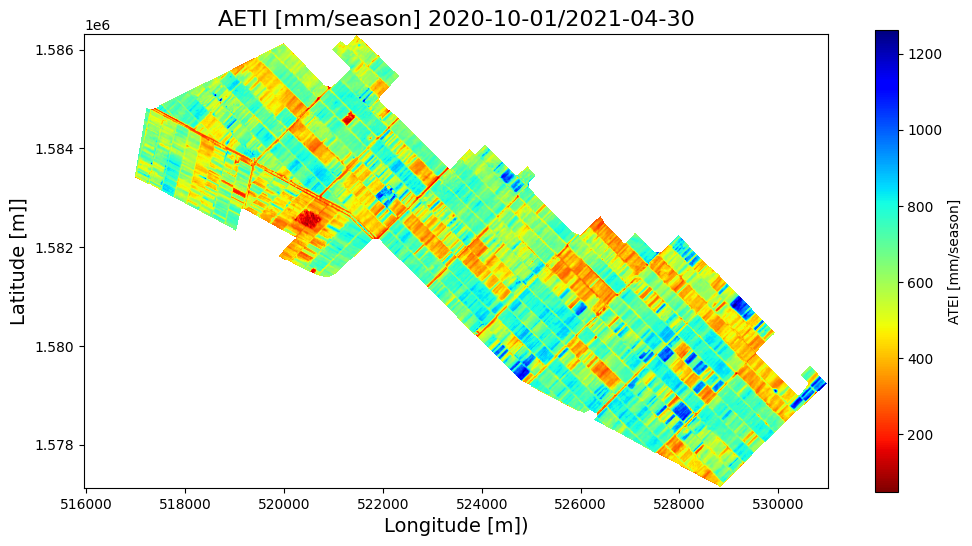

the mean & SD for  2021-10-01/2022-04-30 = 590.9 & 203.9


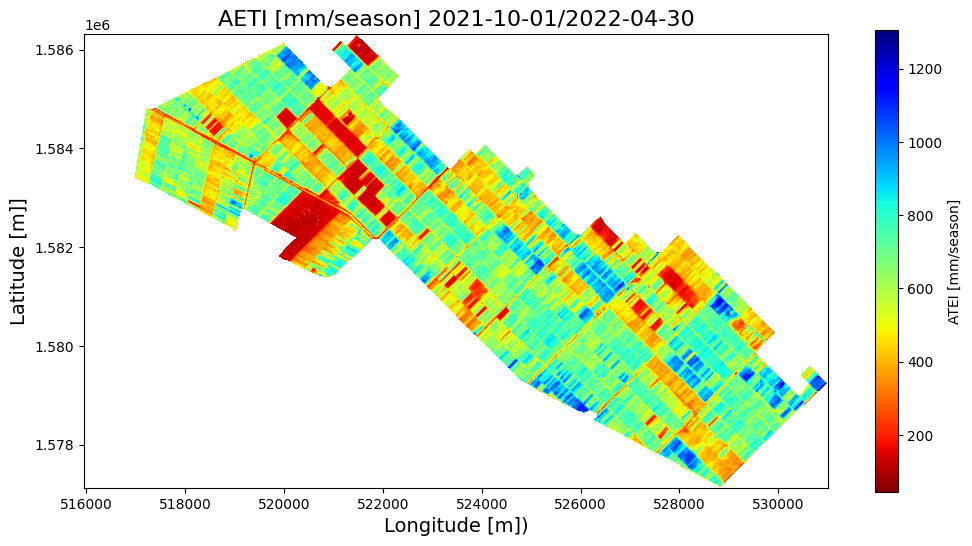

the mean & SD for  2022-10-01/2023-04-30 = 565.8 & 194.1


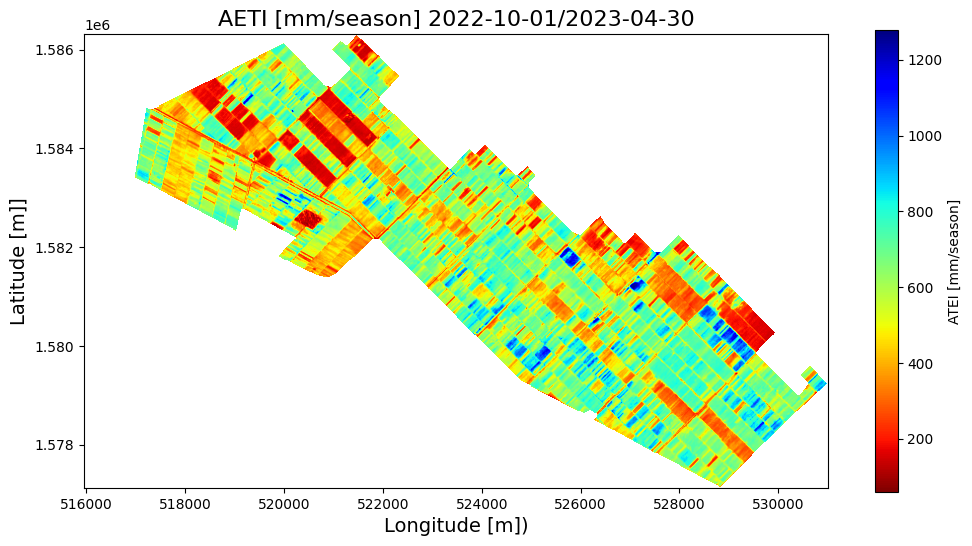

In [28]:
# Assign inputs to the SumSeason function
input_fhs      = input_fhsAETI
output_folder  = output_folderAETI


for i, season in enumerate(season_periods):
    # calculate the seasonal value and save in output_folderT
    SOS = datetime.datetime.strptime(season_periods[season]['SOS'],'%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods[season]['EOS'],'%Y-%m-%d').date()
    seasonal = SumSeason(input_fhs, SOS, EOS)

    ## save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(output_folder, 'AETI' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    seasonal.rio.to_raster(out_fh)

    # calculate the mean, SD
    print ('the mean & SD for ', season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='ATEI [mm/season]')
    plt.xlabel('Longitude [m])', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]]', fontsize=14)
    plt.title('AETI [mm/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], fontsize=16)
    plt.clim()
    plt.show ();

## v) Calculate seasonal Net Primary Production (NPP)

the mean & SD for  2020-10-01/2021-04-30 = 191.6 & 76.1


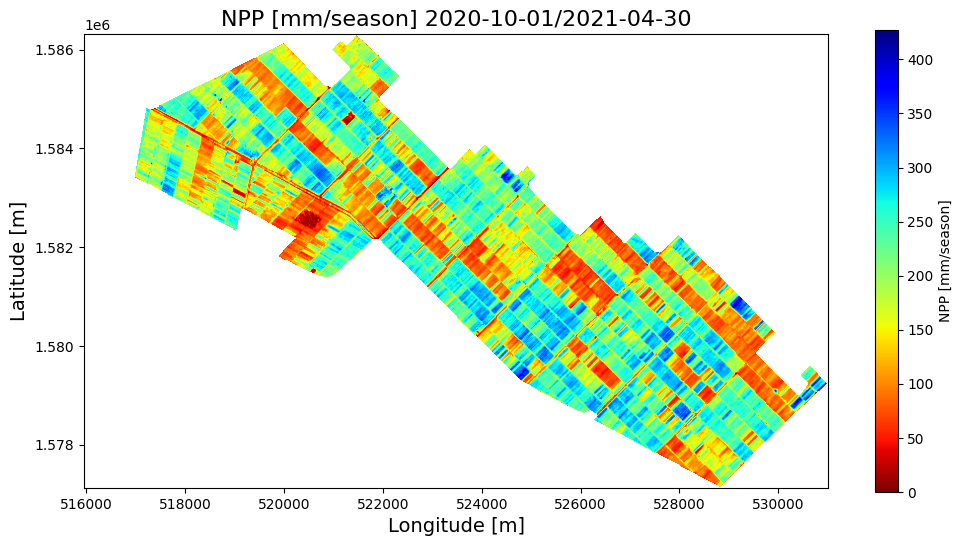

the mean & SD for  2021-10-01/2022-04-30 = 191.0 & 95.8


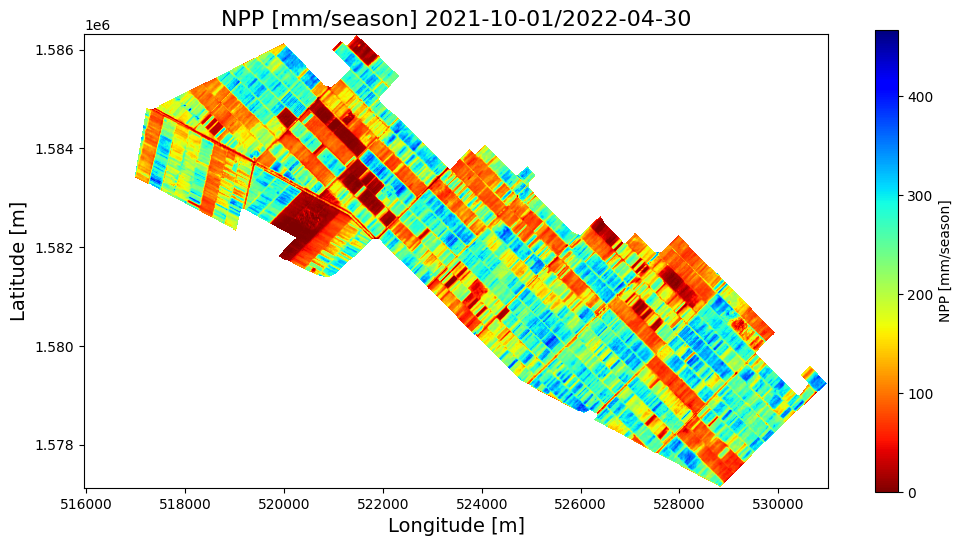

the mean & SD for  2022-10-01/2023-04-30 = 180.9 & 86.8


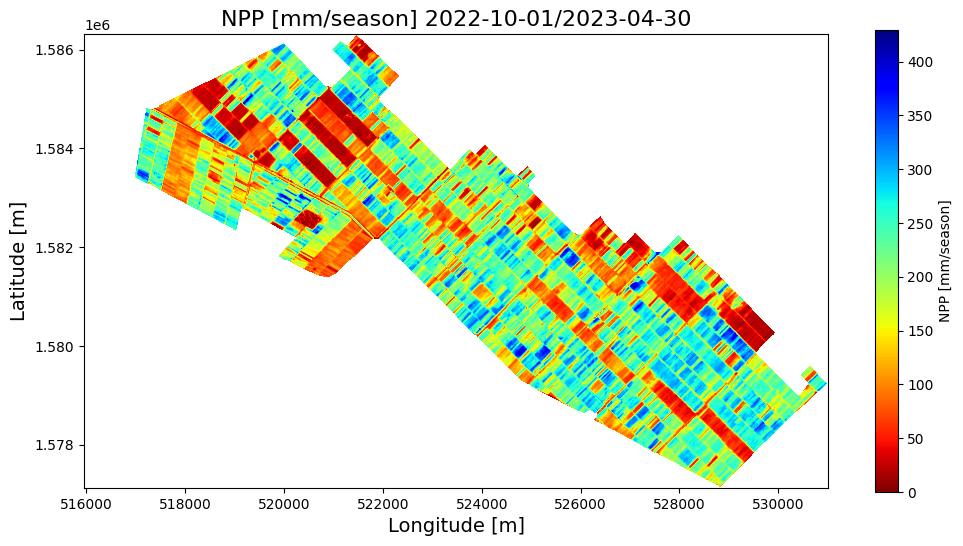

In [29]:
input_fhs      = input_fhsNPP
output_folder  = output_folderNPP


for i, season in enumerate(season_periods):
    # calculate the seasonal value and save in output_folderT
    SOS = datetime.datetime.strptime(season_periods[season]['SOS'],'%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods[season]['EOS'],'%Y-%m-%d').date()
    seasonal = SumSeason(input_fhs, SOS, EOS)

    ## save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(output_folder, 'NPP' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    seasonal.rio.to_raster(out_fh)

    # calculate the mean, SD
    print ('the mean & SD for ', season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='NPP [mm/season]')
    plt.xlabel('Longitude [m]', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title('NPP [mm/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], fontsize=16)
    plt.clim()
    plt.show ();

# Calculating Above ground biomass

In [41]:
dir_proj = os.path.split(os.getcwd())[0]  # os.getcwd() is for the current directory
dir_data = "/content/drive/MyDrive/Python_mooc/Data"
input_folderNPPs = os.path.join(dir_proj, dir_data, "NPP_season")
input_fhsNPPs = glob.glob(os.path.join(input_folderNPPs, '*.tif'))

output_folderBM = os.path.join(dir_proj, dir_data, "AGBM_season")

# if the directory and folder does not exit, make one
if not os.path.exists(output_folderBM):
    os.makedirs(output_folderBM)
output_folderBM

'/content/drive/MyDrive/Python_mooc/Data/AGBM_season'

In [42]:
glob.glob(os.path.join(input_folderNPPs, '*.tif'))

['/content/drive/MyDrive/Python_mooc/Data/NPP_season/NPPseason1_2020-10-01_to_2021-04-30.tif',
 '/content/drive/MyDrive/Python_mooc/Data/NPP_season/NPPseason2_2021-10-01_to_2022-04-30.tif',
 '/content/drive/MyDrive/Python_mooc/Data/NPP_season/NPPseason3_2022-10-01_to_2023-04-30.tif']

the mean & SD for  = 4.3 & 1.7


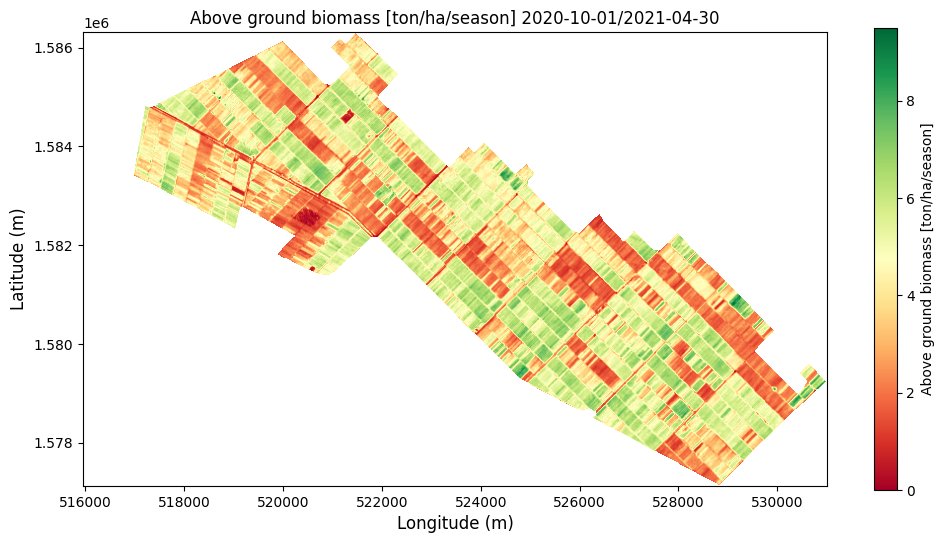

the mean & SD for  = 4.2 & 2.1


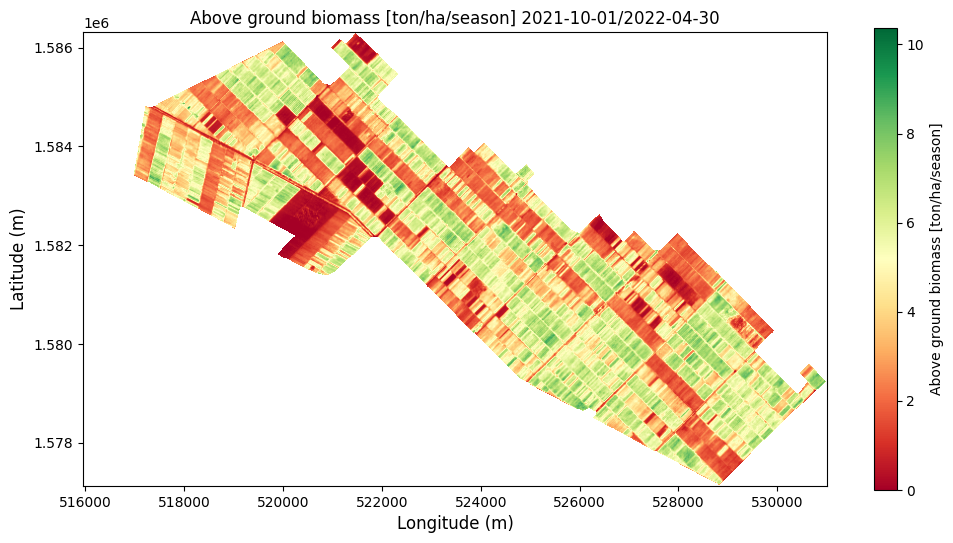

the mean & SD for  = 4.0 & 1.9


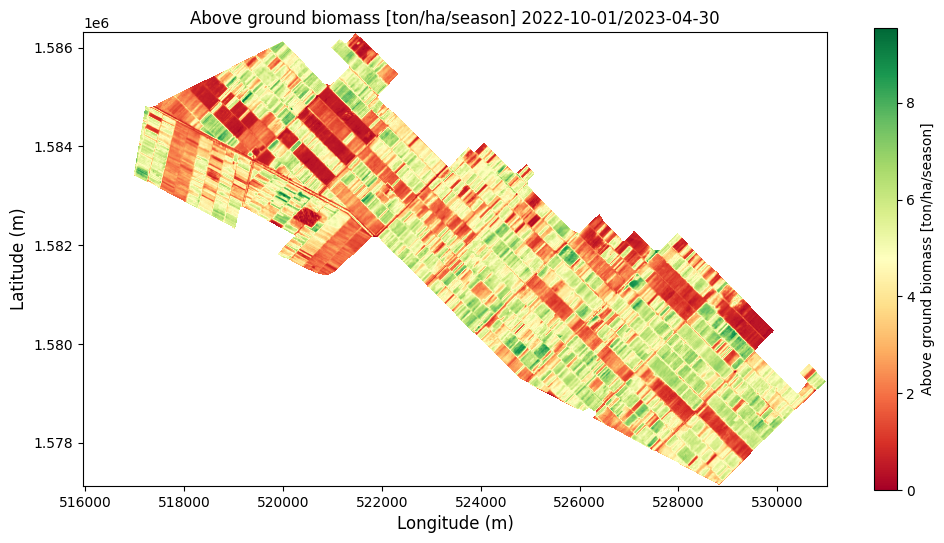

In [43]:

for i, season in enumerate(season_periods):
    NPP  = rio.open_rasterio(input_fhsNPPs[i], nan_values=True)
    AGBM = (NPP * 22.222) / 1000  # Above ground biomass, 1000 is to covert from kg to ton


    # save into output folder
    output_folder = output_folderBM
    out_fh = os.path.join(output_folder, 'AGBM' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    AGBM.rio.to_raster(out_fh)

    # Plot the raster map
    seasonal = AGBM
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())

    # calculate the mean, SD
    print ('the mean & SD for ', '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))


    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='Above ground biomass [ton/ha/season]')
    plt.xlabel('Longitude (m)', fontsize=12)  # add axes label
    plt.ylabel('Latitude (m)', fontsize=12)
    plt.title('Above ground biomass [ton/ha/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'])
    plt.clim()
    plt.show ();

# Calculating Water Productivity

In [44]:
dir_proj = os.path.split(os.getcwd())[0]  # os.getcwd() is for the current directory
dir_data = "/content/drive/MyDrive/Python_mooc/Data"
input_folder1  = os.path.join(dir_proj, dir_data, "AETI_season")
input_fhsET = glob.glob(os.path.join(input_folder1, '*.tif'))

input_folder2 = os.path.join(dir_proj, dir_data, "AGBM_season")
input_fhsAGBM  = glob.glob(os.path.join(input_folder2, '*.tif'))


In [45]:
dir_proj = os.path.split(os.getcwd())[0]
dir_data = "Data"

output_folderWPb = os.path.join(dir_proj, dir_data, "WP_season")

# if the directory and folder does not exit, make one
if not os.path.exists(output_folderWPb):
    os.makedirs(output_folderWPb)
output_folderWPb

'/Data/WP_season'

the mean & SD for  = 0.7 & 0.1


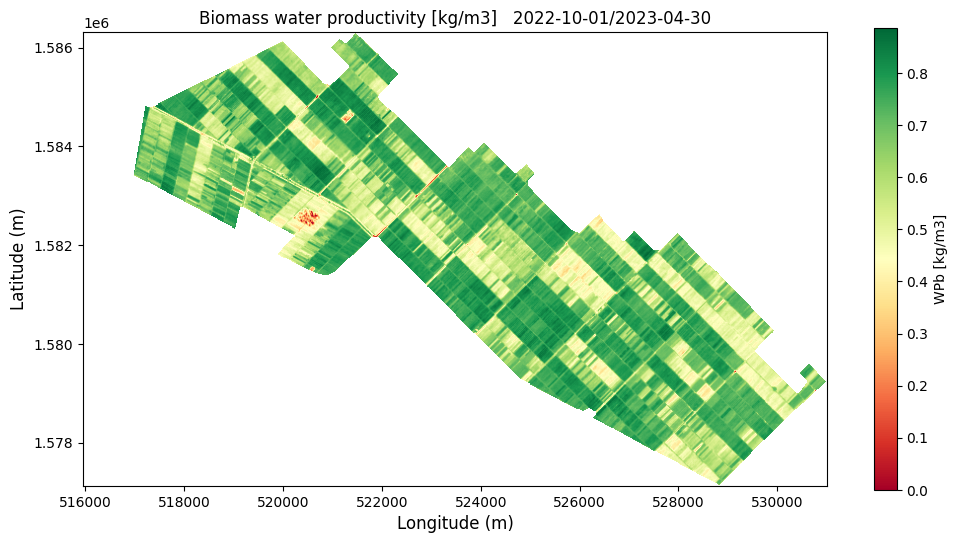

the mean & SD for  = 0.7 & 0.2


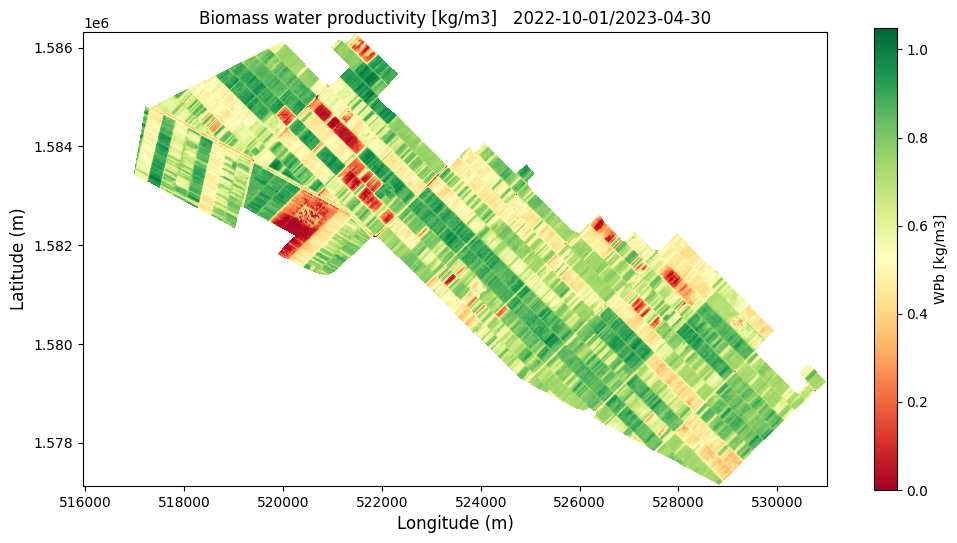

the mean & SD for  = 0.7 & 0.2


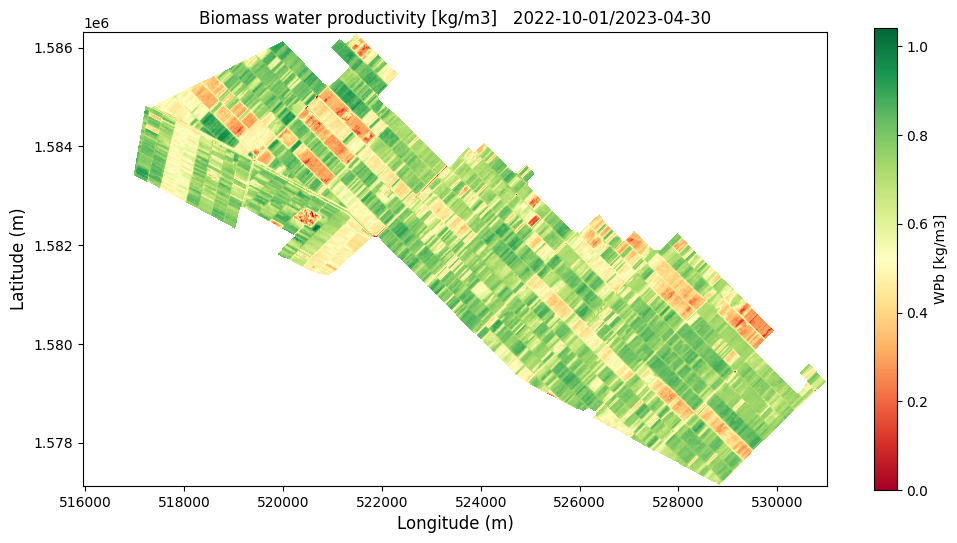

In [46]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsET[0]

## Calculate the WP
for in_fhET, in_fhAGBM in zip(input_fhsET, input_fhsAGBM):
    AETI = rio.open_rasterio(in_fhET, nan_values=True)
    AGBM = rio.open_rasterio(in_fhAGBM, nan_values=True)
    WPb  = AGBM/AETI*100


    # save into output folder
    output_folder = output_folderWPb
    basename      = os.path.basename(in_fhET).replace('ET', 'WPb')
    output_fn     = os.path.join(output_folder, basename)
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())

    # Plot the raster map
    seasonal = WPb

    # calculate the mean, SD
    print ('the mean & SD for ', '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='WPb [kg/m3]')
    plt.xlabel('Longitude (m)', fontsize=12)  # add axes label
    plt.ylabel('Latitude (m)', fontsize=12)
    plt.title('Biomass water productivity [kg/m3]   ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'])
    plt.clim()
    plt.show ()
    ;